In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from collections import OrderedDict
import sklearn
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
import time
from datetime import datetime
device = 'cuda'


In [2]:
dl = False
data_path = './data'
cifar10 = datasets.CIFAR10(data_path, train=True, download=dl, transform=transforms.ToTensor())



train_imgs = torch.stack([img for img, _ in cifar10], dim=3)#.to(device=device)
view = train_imgs.view(3, -1)#.to(device=device)

mean = train_imgs.view(3, -1).mean(dim=1)
std = train_imgs.view(3, -1).std(dim=1)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])


In [3]:
class Classifier(nn.Module):
    @classmethod
    def compare_results(cls, results1, results2):
        print('Comparing results:')
        comparisons = {
            'accuracy': 100*(results1['accuracy'] - results2['accuracy'])/results1['accuracy'],
            'precision': 100*(results1['precision'] - results2['precision'])/results1['precision'],
            'recall': 100*(results1['recall'] - results2['recall'])/results1['recall'],
            'f1': 100*(results1['f1'] - results2['f1'])/results1['f1']
        }
        for key, value in comparisons.items():
            print(f'{key}: {value} %')
        
    def __init__(self):
        super().__init__()
    
    def get_results(self, Y_test=None, Y_pred=None):
        if Y_test is None:
            Y_test = self.last_test
        if Y_pred is None:
            Y_pred = self.last_pred
            
        if isinstance(Y_test, torch.Tensor):
            Y_test = Y_test.cpu().detach().numpy()
        if isinstance(Y_pred, torch.Tensor):
            Y_pred = Y_pred.cpu().detach().numpy()
        results = {
            'accuracy': accuracy_score(Y_test, Y_pred),
            'precision': precision_score(Y_test, Y_pred, average='weighted'),
            'recall': recall_score(Y_test, Y_pred, average='weighted'),
            'f1': f1_score(Y_test, Y_pred, average='weighted'),
            'confusion_matrix': confusion_matrix(Y_test, Y_pred),
            'classification_report': classification_report(Y_test, Y_pred)
        }
        self.last_results = results
        return results
    def print_results(self, results=None):
        if results is None:
            try: 
                results = self.last_results
            except:
                results = self.get_results()
        for key, value in results.items():
            if key in ['confusion_matrix', 'classification_report']:
                print(f'{key.capitalize()}:\n{value}')
            else:
                print(f'{key.capitalize()}: {value}')

In [4]:
class ConvImageClassifier(Classifier):
    def __init__(self, input_dim, conv_layers, fc_layers, activation=nn.ReLU):
        super().__init__()
        
        self.stack = nn.Sequential(OrderedDict(
            [
                ('conv0', nn.Conv2d(in_channels=3, out_channels=conv_layers[0], kernel_size=3, padding=1)),
                ('activation0', activation()),
                ('maxpool0', nn.MaxPool2d(2)),
            ]
        ))
        
        for i in range(1, len(conv_layers)):
            self.stack.add_module(f'conv{i}', nn.Conv2d(in_channels=conv_layers[i-1], out_channels=conv_layers[i], kernel_size=3, padding=1))
            self.stack.add_module(f'activation{i}', activation())
            self.stack.add_module(f'maxpool{i}', nn.MaxPool2d(2))
            
        conv_out = input_dim//(2**len(conv_layers))
        self.stack.add_module('flatten', nn.Flatten())
        self.stack.add_module(f'fc0', nn.Linear(conv_out**2*conv_layers[-1], fc_layers[0]))
        
        for i in range(1, len(fc_layers)):
            self.stack.add_module(f'activation_fc{i}', nn.Tanh())
            self.stack.add_module(f'fc{i}', nn.Linear(fc_layers[i-1], fc_layers[i]))        
        
    def forward(self, x):
        return self.stack(x)
    def predict(self, x):
        with torch.no_grad():
            return self.forward(x).argmax(dim=1)
    def train_model(
        self,
        epochs,
        train_loader,
        test_loader,
        loss_fn=nn.CrossEntropyLoss(),
        optimizer=torch.optim.SGD,
        optimizer_args = [],
        optimizer_kwargs = {},
        print_epoch=10,
        header_epoch = 15
    ):  
        optimizer = optimizer(self.parameters(), *optimizer_args, **optimizer_kwargs)
        training_time = 0
        train_hist = np.zeros(epochs)
        test_hist = np.zeros(epochs)
        accuracy_hist = np.zeros(epochs)
        
        cell_width = 15
        header_form_spec = f'^{cell_width}'
        header_string = f"|{'Epoch':{header_form_spec}}|{'Epoch Time (s)':{header_form_spec}}|{'Training Loss':{header_form_spec}}|{'Test Loss ':{header_form_spec}}|{'Overfit (%)':{header_form_spec}}|{'Accuracy (%)':{header_form_spec}}|{'D Accuracy (%)':{header_form_spec}}|" 
        divider_string = '-'*(cell_width*7 + 8)
        if print_epoch:
            print(f'Training {self.__class__.__name__}\n')
            print(divider_string)
        max_accuracy = 0            
        for epoch in range(epochs):
            begin_epoch = time.time()
            self.train()
            
            start_time = time.time()
            train_loss = 0
            for X_batch, Y_batch in train_loader:
                X_batch, Y_batch = X_batch.to(device, non_blocking=True), Y_batch.to(device, non_blocking=True)
                optimizer.zero_grad()
                Y_pred = self.forward(X_batch)
                loss = loss_fn(Y_pred, Y_batch)
                loss.backward()
                optimizer.step()
                
                train_loss += loss.item()
            training_time += time.time() - start_time
            train_loss = train_loss/len(train_loader)
            train_hist[epoch] = train_loss
            
            
            self.eval()
            with torch.no_grad():
                test_loss = 0
                correct = 0               
                
                for X_test_batch, Y_test_batch in test_loader:
                    X_test_batch, Y_test_batch = X_test_batch.to(device, non_blocking=True), Y_test_batch.to(device, non_blocking=True)
                    
                    out = self.forward(X_test_batch)
                    test_loss += loss_fn(out, Y_test_batch).detach()
                    correct += (out.argmax(dim=1) == Y_test_batch).sum()
                    
            test_loss = test_loss/len(test_loader)
            test_hist[epoch] = test_loss
            accuracy = correct/len(test_loader.dataset)
            accuracy_hist[epoch] = accuracy
            end_epoch = time.time()
            if print_epoch and (epoch % print_epoch == 0 or epoch == epochs - 1) :
                if header_epoch and epoch % header_epoch == 0:
                    print(header_string)
                    print(divider_string)
                epoch_duration = end_epoch - begin_epoch
                overfit = 100 * (test_loss - train_loss) / train_loss
                d_accuracy = 100 * (accuracy - max_accuracy) / max_accuracy
                if accuracy > max_accuracy:
                    max_accuracy = accuracy
                print(f"|{epoch:^{cell_width}}|{epoch_duration:^{cell_width}.5f}|{train_loss:^{cell_width}.8f}|{test_loss:^{cell_width}.8f}|{overfit:^{cell_width}.5f}|{accuracy:^{cell_width}.5f}|{d_accuracy:^{cell_width}.5f}|")
                print(divider_string)

        print(f'\nTraining Time: {training_time} seconds\n')
        
        self.train_hist = train_hist
        self.test_hist = test_hist
        self.accuracy_hist = accuracy_hist
    
    def plot_training(self, title='Training Results'):
        plt.plot(self.train_hist, label='Training Loss')
        plt.plot(self.test_hist, label='Test Loss')
        plt.plot(self.accuracy_hist, label='Accuracy')
        plt.title(title)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()


In [9]:
try:
    del train_loader
    del test_loader
    del model_1a
    del model_1b
except:
    pass

workers = 16
cifar10_train = datasets.CIFAR10(data_path, train=True, download=dl, transform=transform)
cifar10_test = datasets.CIFAR10(data_path, train=False, download=dl, transform=transform)

train_loader = DataLoader(
    cifar10_train,
    batch_size=2048,
    shuffle=True,
    num_workers=workers,
    pin_memory=True,
    prefetch_factor=4
)


test_loader = DataLoader(cifar10_test, batch_size=len(cifar10_test), shuffle=True, num_workers=workers, pin_memory=True, prefetch_factor=4)

model_1a = ConvImageClassifier(
    input_dim = 32,
    conv_layers=[32, 64],
    fc_layers=[32, 10],
    activation=nn.ReLU
).to(device=device)
 
print(model_1a.stack)

model_1a.train_model(
    epochs=200,
    train_loader=train_loader,
    test_loader=test_loader,
    loss_fn=nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam,
    optimizer_kwargs={'lr': 8e-3, 'weight_decay': 1e-2},
    print_epoch=1,
    header_epoch=15
)

del train_loader
del test_loader
del cifar10_train
del cifar10_test

model_1a.plot_training("2 Layer CNN Training Curves")


Sequential(
  (conv0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (activation0): ReLU()
  (maxpool0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (activation1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc0): Linear(in_features=4096, out_features=32, bias=True)
  (activation_fc1): Tanh()
  (fc1): Linear(in_features=32, out_features=10, bias=True)
)
Training ConvImageClassifier

-----------------------------------------------------------------------------------------------------------------
|     Epoch     |Epoch Time (s) | Training Loss |  Test Loss    |  Overfit (%)  | Accuracy (%)  |D Accuracy (%) |
-----------------------------------------------------------------------------------------------------------------
|       0       |    5.55963    |  2.169

Sequential(
  (conv0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (activation0): ReLU()
  (maxpool0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (activation1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (activation2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc0): Linear(in_features=2048, out_features=32, bias=True)
  (activation_fc1): Tanh()
  (fc1): Linear(in_features=32, out_features=10, bias=True)
)
Training ConvImageClassifier

-----------------------------------------------------------------------------------------------------------------
|     Epoch     |Epoch Time (s) | Training Loss |  Test Loss    |  Overfit (%

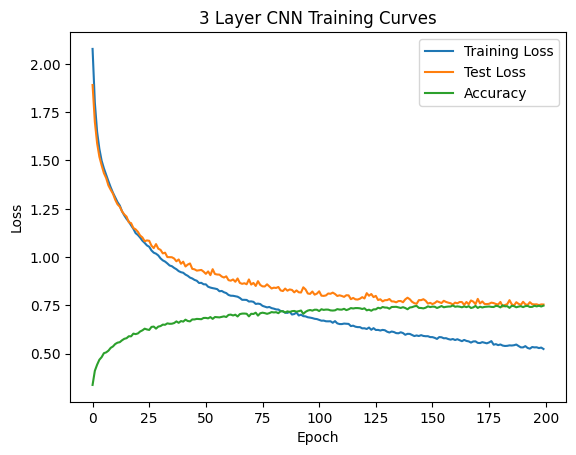

In [5]:
workers = 16

# Deal with loaders sticking around after interrupting training
try:
    del train_loader
    del test_loader
    del model_1b
except:
    pass


cifar10_train = datasets.CIFAR10(data_path, train=True, download=dl, transform=transform)
cifar10_test = datasets.CIFAR10(data_path, train=False, download=dl, transform=transform)

train_loader = DataLoader(
    cifar10_train,
    batch_size=1024,
    shuffle=True,
    num_workers=workers,
    prefetch_factor=4
)
test_loader = DataLoader(cifar10_test, batch_size=len(cifar10_test), shuffle=True, num_workers=workers, pin_memory=True, prefetch_factor=4)

model_1b = ConvImageClassifier(
    input_dim = 32,
    conv_layers=[32, 64, 128],
    fc_layers=[32, 10],
    activation=nn.ReLU
).to(device=device)
 
print(model_1b.stack)

model_1b.train_model(
    epochs=200,
    train_loader=train_loader,
    test_loader=test_loader,
    optimizer = torch.optim.Adam,
    optimizer_kwargs={'lr': 3e-4, 'weight_decay': 1e-2}, #Increase alpha to 2 next time
    loss_fn=nn.CrossEntropyLoss(),
    print_epoch=1
)
del train_loader
del test_loader
model_1b.plot_training("3 Layer CNN Training Curves")


In [ ]:
try:
    del train_loader
    del test_loader
    del model_1b
except:
    pass


cifar10_train = datasets.CIFAR10(data_path, train=True, download=dl, transform=transform)
cifar10_test = datasets.CIFAR10(data_path, train=False, download=dl, transform=transform)

train_loader = DataLoader(
    cifar10_train,
    batch_size=1024,
    shuffle=True,
    num_workers=workers,
    prefetch_factor=4
)
test_loader = DataLoader(cifar10_test, batch_size=len(cifar10_test), shuffle=True, num_workers=workers, pin_memory=True, prefetch_factor=4)